# Import Packages

For now, we will assume no packages need to be installed in Python environment.

In [1]:
import sys
sys.path.append("..")

import os
import utilsKinematics
from utilsPlotting import plot_dataframe, plot_dataframe_xyz
import matplotlib.pyplot as plt
import numpy as np
import json
import cv2
from scipy.signal import find_peaks
import pandas as pd
from scipy.fft import fft, ifft

# Load Locally Stored Data

First, specify data folder name within local `Data` folder in the parent directory of this notebook, and specify motions of interest to run analysis on. The data analyzed in this notebook is taken directly from OpenCap's open source dataset.

To load OpenCap data in format supported by this analysis pipeline, extract motion files from `OpenSimData/Mocap/IK` and place in the `OpenSimData/Kinematics` subfolder locally. For marker data, extract marker files (typically .trc) from `MarkerData/Mocap/` and place in the `MarkerData/` subfolder locally. Finally, find the scaled OpenSim model and place in the local `OpenSimData/Model` subfolder. Here, we're using Mocap (motion capture) data instead of OpenCap's video data for precision purposes. However, since data from OpenCap videos and Mocap are both saved and stored in identical formats, all analysis completed with this Mocap data can also be applied directly to OpenCap video data.

Note these motion and marker files most likely will only track movements for a subset of their corresponding AVI videos, so make sure to check the timestamps of the motion files and adjust analysis accordingly.

Here, for each of the trials we load in the following block, the code below calculates the following:
1.  OpenSim values, speeds, and accelerations (in deg)
2.  muscle-tendon lengths
3.  center of mass values, speeds, and accelerations.
4.  Directory of OpenSim marker 3D coordinates over time (XYZ coords)


In [2]:
# User inputs
subject = "subject4"
session = "Session0"
cam = 'Cam0'

In [3]:
# Preset Path Params
trials_of_interest = ['DJ1', 'DJ2', 'DJ3', 'DJ4', 'DJ5', 'DJAsym1', 'DJAsym2', 'DJAsym3', 'DJAsym4', 'DJAsym5', 'squats1', 'squatsAsym1', 'STS1', 'STSweakLegs1']
trials_of_interest += ['walking1', 'walking2', 'walking3', 'walking4', 'walkingTS1', 'walkingTS2', 'walkingTS3', 'walkingTS4']

data_folder_name = str('opencap_LabValidation_withVideos_'+subject+'_VideoData_'+session)
data_folder = os.path.join(os.getcwd(), "../Data", data_folder_name)
json_data_folder_name = str('movenet_opencap_LabValidation_withVideos_'+subject+'_VideoData_'+session+'_'+cam)
json_study_prefix = str(data_folder_name+'_'+cam+'_')
json_data_folder = os.path.join(os.getcwd(), "../Data", json_data_folder_name)
avi_data_folder = str('/Users/davidspector/Home/OpenMotion/LabValidation_withVideos/'+subject+'/VideoData/'+session+'/'+cam)

model_path = os.path.join(data_folder, 'OpenSimData', 'Model')
for file in os.listdir(model_path):
    if file.endswith('.osim'):
        model_name = file[:-5]
        break

In [4]:
# Process data.
trial_names = []
kinematics, coordinates, muscle_tendon_lengths, moment_arms, center_of_mass, marker_coordinates = {}, {}, {}, {}, {}, {}
coordinates['values'], coordinates['speeds'], coordinates['accelerations'] = {}, {}, {}
center_of_mass['values'], center_of_mass['speeds'], center_of_mass['accelerations'] = {}, {}, {}

for file in os.listdir(os.path.join(data_folder, 'OpenSimData', 'Kinematics')):
    if file.endswith('.mot') and file[:-4] in trials_of_interest:
        trial_name = file[:-4]

        # Create object from class kinematics.
        kinematics[trial_name] = utilsKinematics.kinematics(data_folder, trial_name, modelName=model_name, lowpass_cutoff_frequency_for_coordinate_values=10)
        
        # Get coordinate values, speeds, and accelerations.
        coordinates['values'][trial_name] = kinematics[trial_name].get_coordinate_values(in_degrees=True) # already filtered
        coordinates['speeds'][trial_name] = kinematics[trial_name].get_coordinate_speeds(in_degrees=True, lowpass_cutoff_frequency=10)
        coordinates['accelerations'][trial_name] = kinematics[trial_name].get_coordinate_accelerations(in_degrees=True, lowpass_cutoff_frequency=10)
        
        # Get muscle-tendon lengths.
        muscle_tendon_lengths[trial_name] = kinematics[trial_name].get_muscle_tendon_lengths()
        
        # Get center of mass values, speeds, and accelerations.
        center_of_mass['values'][trial_name] = kinematics[trial_name].get_center_of_mass_values(lowpass_cutoff_frequency=10)
        center_of_mass['speeds'][trial_name] = kinematics[trial_name].get_center_of_mass_speeds(lowpass_cutoff_frequency=10)
        center_of_mass['accelerations'][trial_name] = kinematics[trial_name].get_center_of_mass_accelerations(lowpass_cutoff_frequency=10)

        # Get model coordinates
        marker_coordinates[trial_name] = kinematics[trial_name].get_marker_dict(data_folder, trial_name)
        marker_coordinates[trial_name]['markers']['time'] = marker_coordinates[trial_name]['time']

        trial_names.append(trial_name)

In [5]:
# Load JSON files
keypoints_order = ['nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear', 'left_shoulder', 'right_shoulder', 
                   'left_elbow', 'right_elbow', 'left_wrist', 'right_wrist', 'left_hip', 'right_hip', 'left_knee',
                   'right_knee', 'left_ankle', 'right_ankle']

movenet_outputs = {}
for trial_name in trial_names:
    trial_path = os.path.join(json_data_folder, str(json_study_prefix + trial_name + '.json'))
    if os.path.exists(trial_path):
        file = open(trial_path)
        json_dict = json.load(file)
        movenet_outputs[trial_name] = {}
        for j in range(17): # ignore confidence score for now
            movenet_outputs[trial_name][keypoints_order[j]] = np.ones((len(json_dict),2))
        for i in range(len(json_dict)):
            for j in range(17):
                movenet_outputs[trial_name][keypoints_order[j]][i] = json_dict[i]['keypoints'][j*3:(j*3)+2]
        avi_path = os.path.join(avi_data_folder, trial_name, str(trial_name + '_syncdWithMocap.avi'))
        avi_vid = cv2.VideoCapture(avi_path)
        fps = avi_vid.get(cv2.CAP_PROP_FPS)
        frames = avi_vid.get(cv2.CAP_PROP_FRAME_COUNT)
        movenet_outputs[trial_name]['time'] = np.arange(0, (1/fps)*len(json_dict), 1/fps)
        if len(movenet_outputs[trial_name]['time']) > len(movenet_outputs[trial_name]['right_hip']):
            movenet_outputs[trial_name]['time'] = movenet_outputs[trial_name]['time'][:len(movenet_outputs[trial_name]['right_hip'])]
        elif len(movenet_outputs[trial_name]['time']) < len(movenet_outputs[trial_name]['right_hip']):
            movenet_outputs[trial_name]['time'] = np.append(movenet_outputs[trial_name]['time'], movenet_outputs[trial_name]['time'][-1]+(movenet_outputs[trial_name]['time'][1]-movenet_outputs[trial_name]['time'][0]))
        file.close()

# Position Analysis

For Movenet position-wise validation, we're interested in the body features present in both COCO format and in OpenSim models. These body features are right/left shoulder, right/left elbow, right/left wrist, right/left wrist, right/left hip, right/left knee, and right/left ankle.

Below, we look at the vertical position of the right shoulder across 4 drop jump trials completed on the same model. Unlike the motion files shown later, these positional coordinates appear to have values for the entirety of each video. As indicated in the header of the trc files storing the markers, each marker position is stored in mm. While we do have the ability to plot position across all 3 axes in 3D space, the vertical axis is the only one not dependant on model orientation, which is why we've only plotted positions across this axis.

Also, note that although each trial is completed in roughly the same manner, they occur at different times in the video, showing that OpenCap's dataset doesn't synchronize it's trials across the temporal axis.


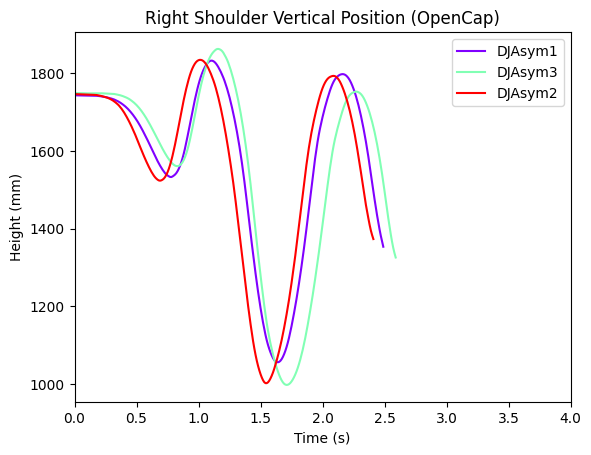

In [6]:
fig = plot_dataframe_xyz(dataframes = [marker_coordinates[trial_names[0]]['markers'],
                                 marker_coordinates[trial_names[1]]['markers'],
                                 marker_coordinates[trial_names[2]]['markers']],
                    y = ['R_Shoulder'],
                    xlabel = 'Time (s)',
                    ylabel = str('Height (' + marker_coordinates[trial_names[0]]['units'] + ')'),
                    title = 'Right Shoulder Vertical Position (OpenCap)',
                    labels = [trial_names[0], trial_names[1], trial_names[2]],
                    xrange = [0, 4],
                    xyz_ind = 1
                    )

fig.set_visible(True)

# Time Synchronization

Although the plot above shows that the trials in this dataset aren't necessarily synced by time. The following section illustrates how the video interval where motion was recorded and analyzed are still synchronized. We will plot the motion intervals on top of raw position data over time, and then layer these motion intervals to show their correlation.

Also, note how these correlations hold across all body parts, indicating the entire motions have been synchronized across trials. We illustrate this point with the right shoulder and right hip.

In [7]:
def get_interval_indices(times, start_time, end_time):
    start_time_index = -1
    end_time_index = -1
    for i in range(len(times)):
        if start_time <= times[i] and start_time_index == -1:
            start_time_index = i
        if end_time <= times[i] and end_time_index == -1:
            end_time_index = i
    
    if start_time_index == -1:
        start_time_index = len(times) - 1
    if end_time_index == -1:
        end_time_index = len(times) - 1

    return start_time_index, end_time_index

In [8]:
# Get start and end times for all trials from saved motion
num_trials = len(trial_names)
start_times = []
end_times = []
time_arrays = list(np.empty(num_trials))
start_time_indices = list(np.empty(num_trials))
end_time_indices = list(np.empty(num_trials))

for i in range(num_trials):
    start_time = kinematics[trial_names[i]].time[0]
    end_time = kinematics[trial_names[i]].time[-1]
    start_times.append(start_time)
    end_times.append(end_time)
    time_array = marker_coordinates[trial_names[i]]['markers']['time']
    start_time_indices[i], end_time_indices[i] = get_interval_indices(time_array, start_times[i], end_times[i])
    time_arrays[i] = time_array[start_time_indices[i]:end_time_indices[i]+1] - time_array[start_time_indices[i]]

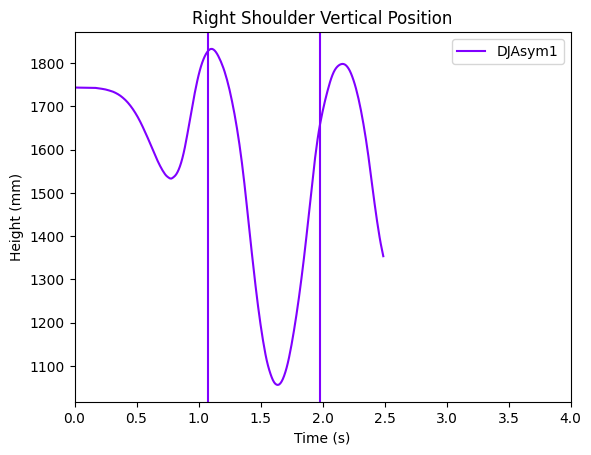

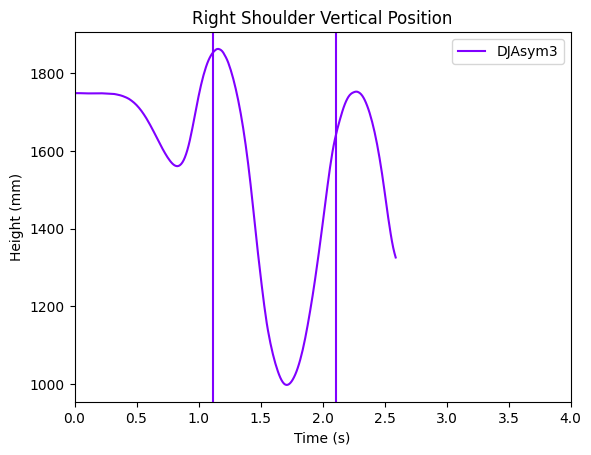

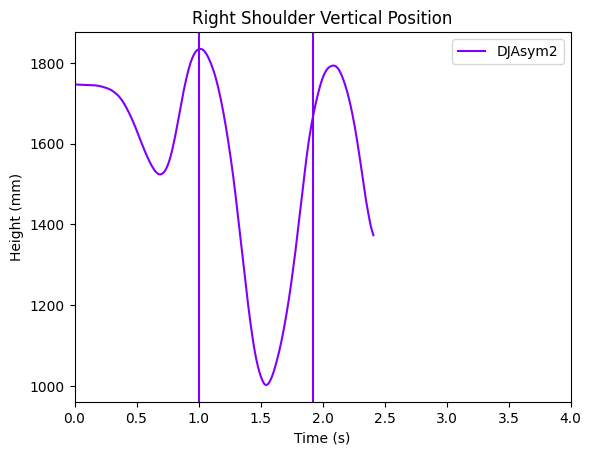

In [9]:
# Plot motion intervals for each drop jump trial
c_color=plt.cm.rainbow(0) 
for i in range(3):
    fig = plot_dataframe_xyz(dataframes = [marker_coordinates[trial_names[i]]['markers']],
                        y = ['R_Shoulder'],
                        xlabel = 'Time (s)',
                        ylabel = str('Height (' + marker_coordinates[trial_names[i]]['units'] + ')'),
                        title = 'Right Shoulder Vertical Position',
                        labels = [trial_names[i]],
                        xrange = [0, 4],
                        xyz_ind = 1
                        )
    plt.axvline(x = start_times[i], color = c_color)
    plt.axvline(x = end_times[i], color = c_color) 

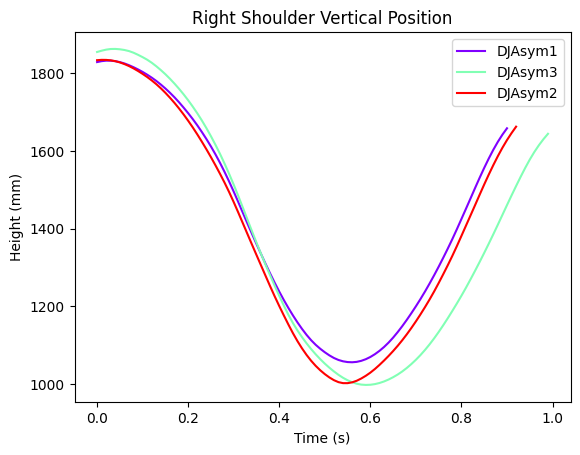

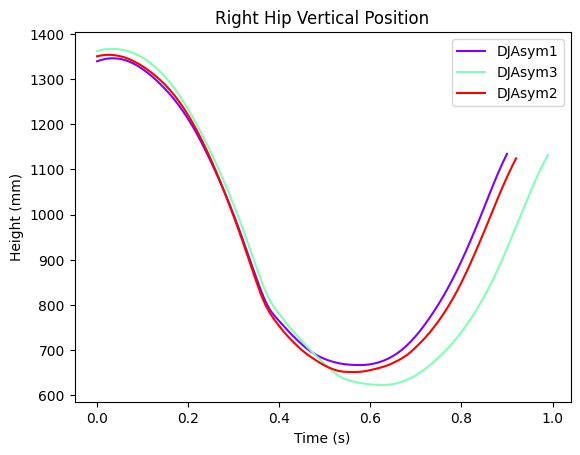

In [10]:
fig = plt.figure()

color=iter(plt.cm.rainbow(np.linspace(0,1,3))) 
for i in range(3):
    c_color = next(color)
    plt.plot(time_arrays[i], marker_coordinates[trial_names[i]]['markers']['R_Shoulder'][start_time_indices[i]:end_time_indices[i]+1,1],
             color = c_color, label = trial_names[i])
plt.legend()
plt.title("Right Shoulder Vertical Position")
plt.xlabel("Time (s)")
plt.ylabel("Height (mm)")

fig = plt.figure()
color=iter(plt.cm.rainbow(np.linspace(0,1,3))) 
for i in range(3):
    c_color = next(color)
    plt.plot(time_arrays[i], marker_coordinates[trial_names[i]]['markers']['r.ASIS'][start_time_indices[i]:end_time_indices[i]+1,1],
             color = c_color, label = trial_names[i])
plt.legend()
plt.title("Right Hip Vertical Position")
plt.xlabel("Time (s)")
plt.ylabel("Height (mm)")
fig.set_visible(True)
    

# Deriving Joint Angle Correlations from Position Data

In this section, we'll go through how the relationship between manually calculated joint angles and OpenSim's automatically calculated joint angles. We will use our time results from last section to synchronize positional and movement angle data across the temporal plane. For this particular case, we will examine knee angle, and calculate it as the angle between the right ASIS and the right outside ankle. Since OpenSim calculates joint angle using it's skeletal model, so we will be comparing the difference in results between angle computation approaches.

Note how the calculated measurements for all movements follow the same correlation across all movements. In movement sections where the model bends its knee at a large angle, OpenSim's angles are consistently larger than our manual calculations. This may be because the right ASIS is in front of the femur bone, which would make our calculated angle measurement indicate less of a bend than a skeletal OpenSim model would. 

A major limitation of this approach is the fact that OpenCap's dataset doesn't contain any position markers for model bone positions.

In [11]:
def angle_from_center(center, v1, v2, acute=True, deg=True):
    norm_v1 = v1 - center
    norm_v2 = v2 - center
    angle = np.arccos(np.dot(norm_v1, norm_v2) / (np.linalg.norm(norm_v1) * np.linalg.norm(norm_v2)))
    if acute:
        if deg:
            return angle * 180 / np.pi
        return angle
    else:
        angle = np.pi - angle
        if deg:
            return angle * 180 / np.pi
        return angle

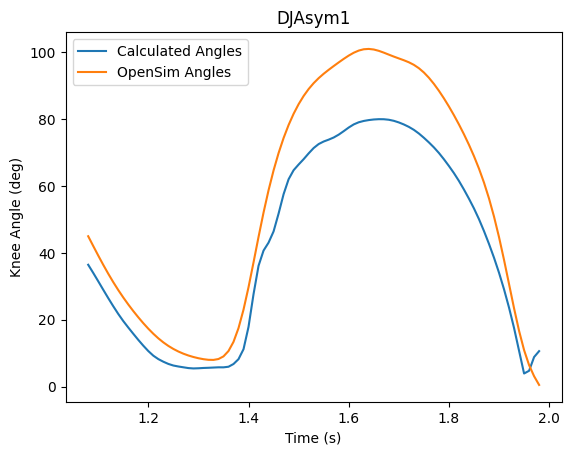

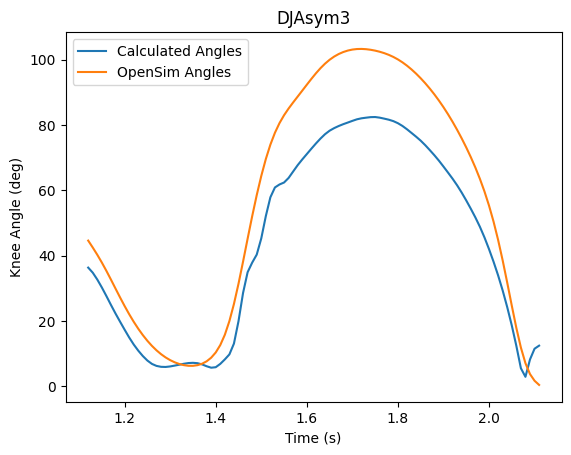

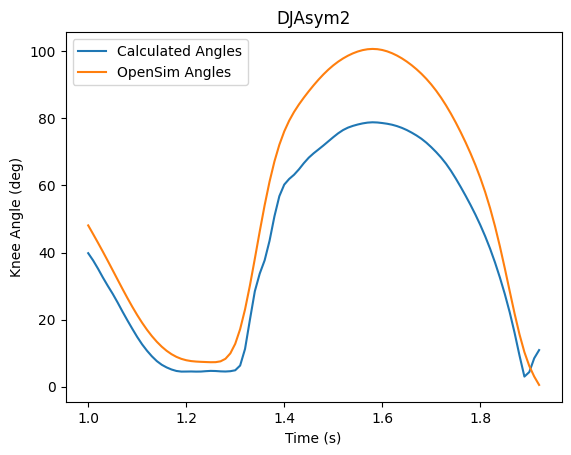

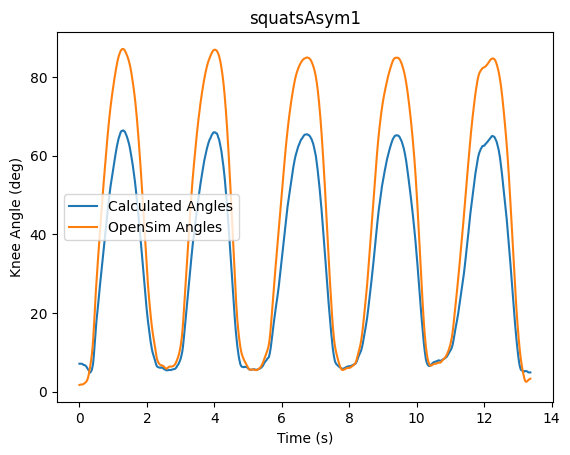

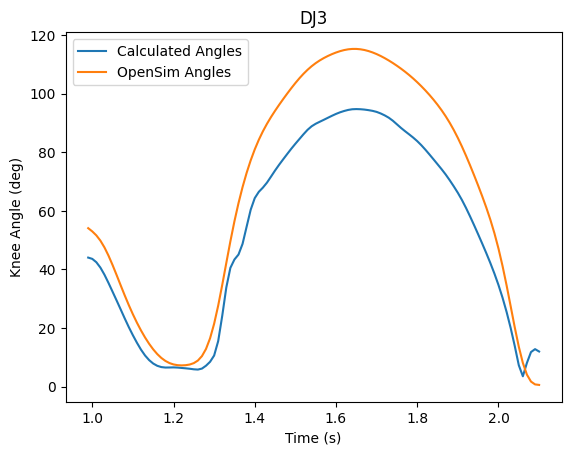

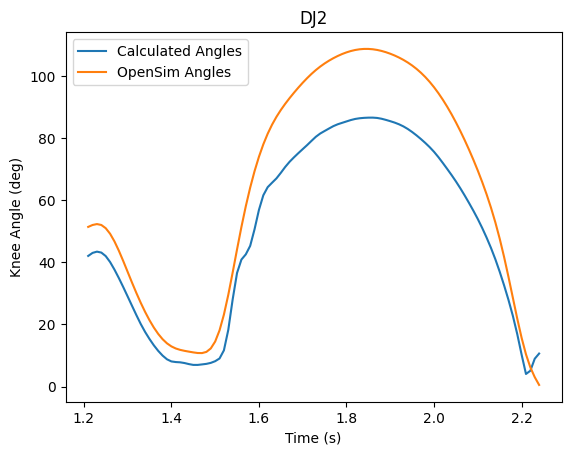

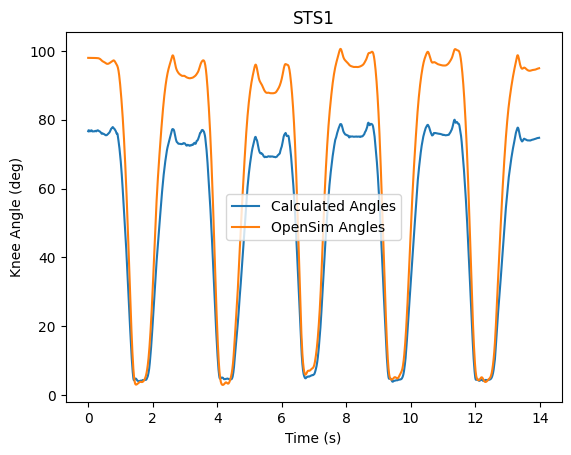

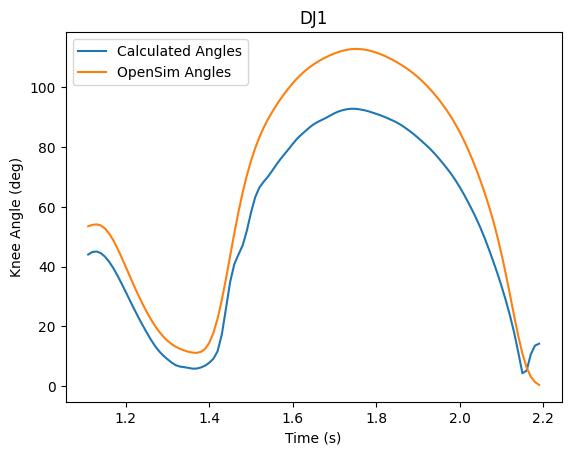

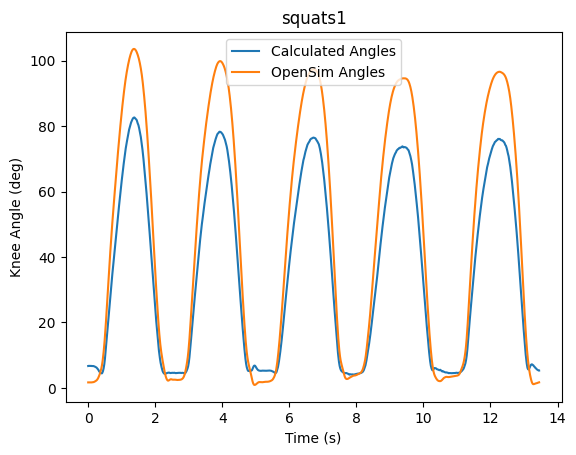

In [12]:
mean_abs_diffs = []

for trial_index in range(num_trials):
    r_knee_positions = marker_coordinates[trial_names[trial_index]]['markers']['r_knee']
    r_hip_positions = marker_coordinates[trial_names[trial_index]]['markers']['r.ASIS']
    r_ankle_positions = marker_coordinates[trial_names[trial_index]]['markers']['r_ankle']
    knee_angles = []
    for i in range(start_time_indices[trial_index], end_time_indices[trial_index]+1):
        knee_angles.append(angle_from_center(r_knee_positions[i], r_ankle_positions[i], r_hip_positions[i], acute=False, deg=True))

    plt.plot(time_arrays[trial_index]+start_times[trial_index], knee_angles, label="Calculated Angles")
    plt.plot(time_arrays[trial_index]+start_times[trial_index], coordinates['values'][trial_names[trial_index]]['knee_angle_r'], label="OpenSim Angles")
    plt.xlabel("Time (s)")
    plt.ylabel("Knee Angle (deg)")
    plt.title(trial_names[trial_index])
    plt.legend()
    plt.show()

    squared_diff = abs(knee_angles - coordinates['values'][trial_names[trial_index]]['knee_angle_r'])
    mean_abs_diffs.append(np.mean(squared_diff))

In [13]:
# Angle estimation error results
print("Mean absolute angle estimation error across all trials:", np.mean(mean_abs_diffs))
print("Min absolute angle estimation error across all trials:", np.min(mean_abs_diffs))
print("Max absolute angle estimation error across all trials:", np.max(mean_abs_diffs))
print("Standard deviation of absolute angle estimation error across all trials:", np.std(mean_abs_diffs))

Mean absolute angle estimation error across all trials: 13.408846077511619
Min absolute angle estimation error across all trials: 11.910760129312573
Max absolute angle estimation error across all trials: 15.423351722637932
Standard deviation of absolute angle estimation error across all trials: 1.0752386063302708


# Position Analysis

For Movenet position-wise validation, we're interested in the body features present in both COCO format and in OpenSim models. These body features are right/left shoulder, right/left elbow, right/left wrist, right/left wrist, right/left hip, right/left knee, and right/left ankle.

Below, we look at the vertical position of the right shoulder across 4 drop jump trials completed on the same model. Unlike the motion files shown later, these positional coordinates appear to have values for the entirety of each video. As indicated in the header of the trc files storing the markers, each marker position is stored in mm. While we do have the ability to plot position across all 3 axes in 3D space, the vertical axis is the only one not dependant on model orientation, which is why we've only plotted positions across this axis.

Also, note that although each trial is completed in roughly the same manner, they occur at different times in the video, showing that OpenCap's dataset doesn't synchronize it's trials across the temporal axis.

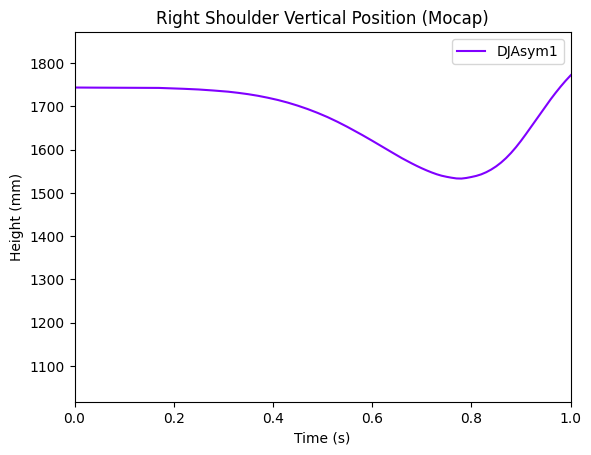

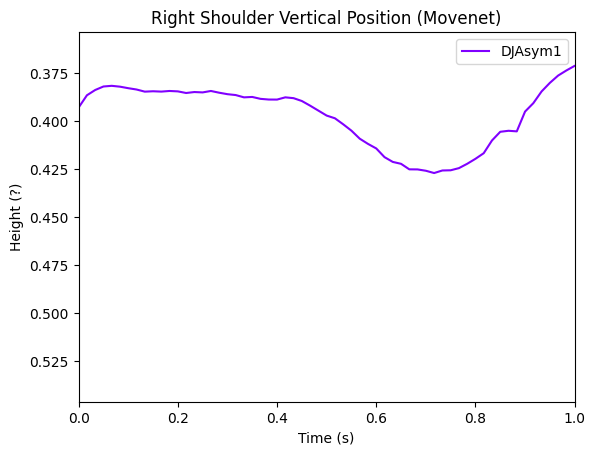

In [14]:
# trial_names = ['DJ1', 'DJ2', 'DJ4', 'DJAsym1', 'DJAsym2', 'DJAsym4', 'squats1', 'squatsAsym1', 'walking1', 'walking2', 'walking3']
fig = plot_dataframe_xyz(dataframes = [marker_coordinates[trial_names[0]]['markers']],
                    y = ['R_Shoulder'],
                    xlabel = 'Time (s)',
                    ylabel = str('Height (' + marker_coordinates[trial_names[0]]['units'] + ')'),
                    title = 'Right Shoulder Vertical Position (Mocap)',
                    labels = [trial_names[0]],
                    xrange = [0, 1],
                    xyz_ind = 1
                    )

fig.set_visible(True)

fig = plot_dataframe_xyz(dataframes = [movenet_outputs[trial_names[0]]],
                    y = ['right_shoulder'],
                    xlabel = 'Time (s)',
                    ylabel = str('Height (?)'),
                    title = 'Right Shoulder Vertical Position (Movenet)',
                    labels = [trial_names[0]],
                    xrange = [0, 1],
                    xyz_ind = 0
                    )

fig.set_visible(True)
plt.gca().invert_yaxis()

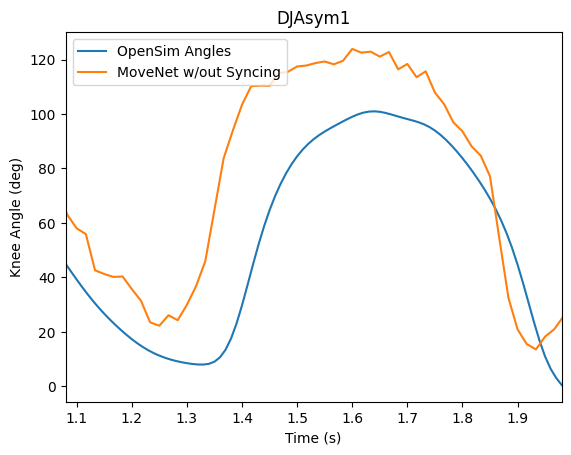

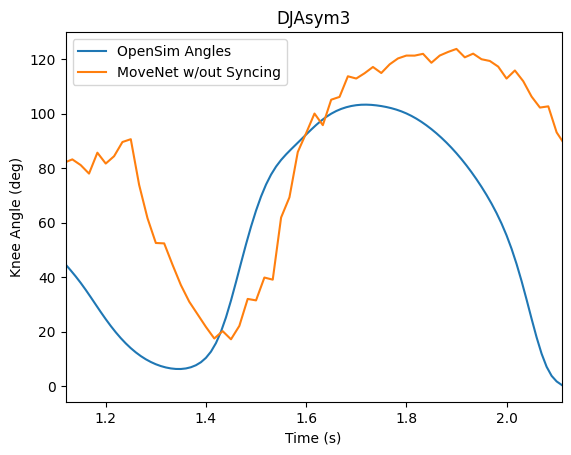

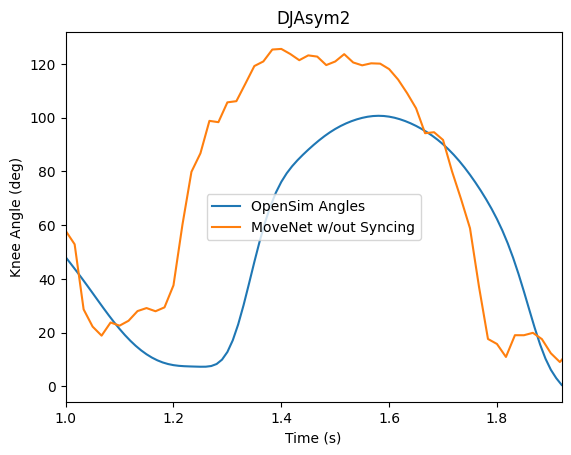

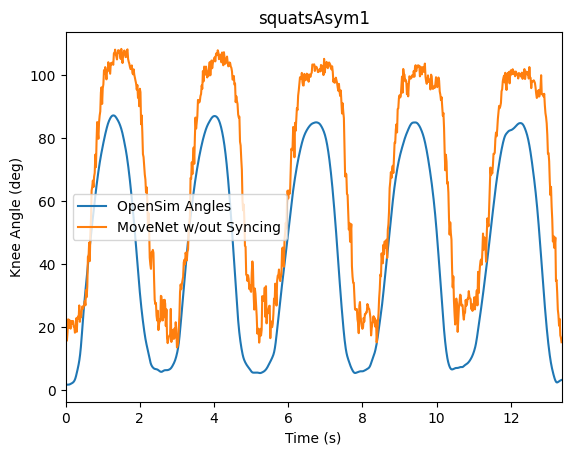

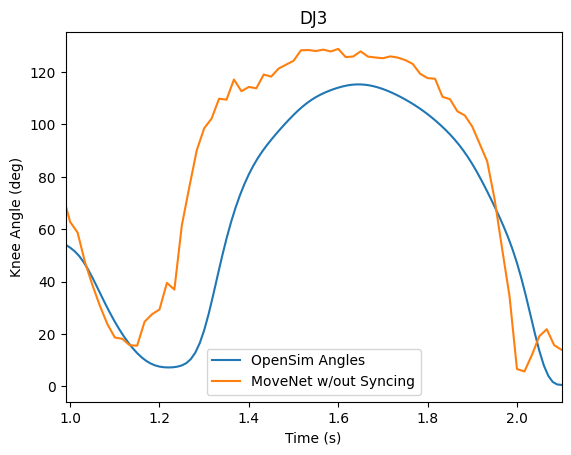

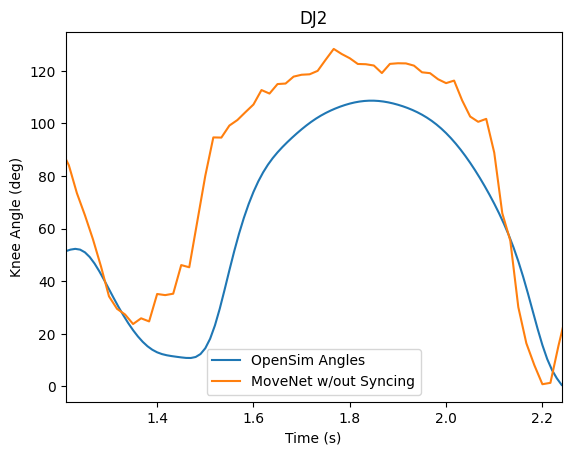

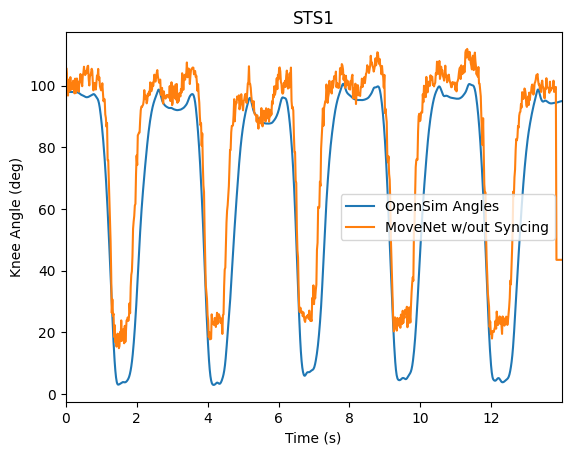

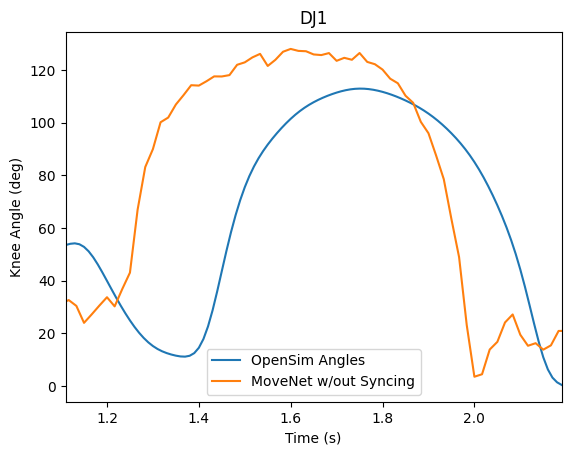

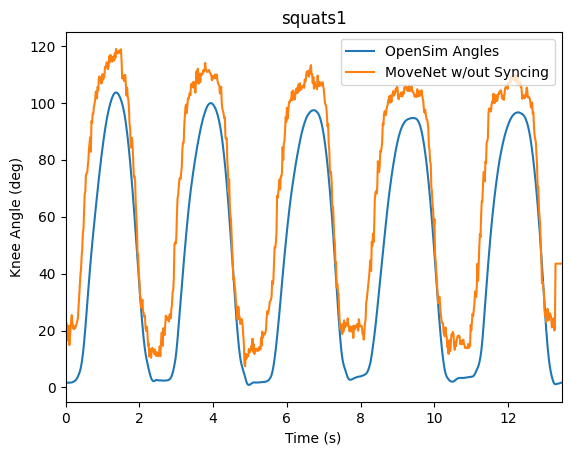

In [15]:
mean_abs_diffs = []
mv_knee_angles = []
marker_knee_angles = []

for trial_index in range(num_trials):
    r_knee_positions = marker_coordinates[trial_names[trial_index]]['markers']['r_knee']
    r_hip_positions = marker_coordinates[trial_names[trial_index]]['markers']['r.ASIS']
    r_ankle_positions = marker_coordinates[trial_names[trial_index]]['markers']['r_ankle']
    knee_angles = []
    for i in range(start_time_indices[trial_index], end_time_indices[trial_index]+1):
        knee_angles.append(angle_from_center(r_knee_positions[i], r_ankle_positions[i], r_hip_positions[i], acute=False, deg=True))

    try:
        mv_r_knee = movenet_outputs[trial_names[trial_index]]['right_knee']
    except:
        continue
    mv_r_hip = movenet_outputs[trial_names[trial_index]]['right_hip']
    mv_r_ankle = movenet_outputs[trial_names[trial_index]]['right_ankle']
    cur_mv_knee_angles = []
    for i in range(len(movenet_outputs[trial_names[trial_index]]['time'])):
        cur_mv_knee_angles.append(angle_from_center(mv_r_knee[i], mv_r_ankle[i], mv_r_hip[i], acute=False, deg=True))

    # plt.plot(time_arrays[trial_index]+start_times[trial_index], knee_angles, label="Calculated Angles")
    plt.plot(time_arrays[trial_index]+start_times[trial_index], coordinates['values'][trial_names[trial_index]]['knee_angle_r'], label="OpenSim Angles")
    plt.plot(movenet_outputs[trial_names[trial_index]]['time'], cur_mv_knee_angles, label="MoveNet w/out Syncing")
    plt.xlabel("Time (s)")
    plt.ylabel("Knee Angle (deg)")
    plt.xlim(time_arrays[trial_index][0]+start_times[trial_index],time_arrays[trial_index][-1]+start_times[trial_index])
    plt.title(trial_names[trial_index])
    plt.legend()
    plt.show()

    squared_diff = abs(knee_angles - coordinates['values'][trial_names[trial_index]]['knee_angle_r'])
    mean_abs_diffs.append(np.mean(squared_diff))
    mv_knee_angles.append(cur_mv_knee_angles)
    marker_knee_angles.append(knee_angles)

# Time Syncing via Algorithm

As stated in OpenCap's paper, "Prior to error analysis, we synchronized and aligned Mocap and OpenCap position data by removing the time delay that minimized the mean difference between marker positions (averaged over all markers and time steps), then subtracting this average position offset from the OpenCap positions."

To reconcile this action with our MoveNet validation, we will use a similar synchronization algorithm to resolve our time syncing issue.

In [16]:
from scipy.signal import butter, filtfilt

def dist(x,y):
    # return np.sqrt((x[0]-y[0])**2 + (x[1]-y[1])**2)
    dist = abs(x[1]-y[1])
    # if dist <= 6:
    #     return 0
    # dist -= 6
    return (dist)**10

def find_optimal_x_position(sliding_plot, fixed_plot, window=400, cutoff=30):
    distances = []

    for win in range(window, 1, -1):
        # Slide sliding plot across the X axis starting from left
        total_dist = 0
        for i in range(0, len(sliding_plot)-win-cutoff):
            total_dist += dist(sliding_plot[i+win], fixed_plot[i])
        
        distances.append(np.mean(total_dist))
    
    for win in range(window):
        # Slide sliding plot across the X axis starting from original start
        total_dist = 0
        for i in range(cutoff, len(sliding_plot)-win):
            total_dist += dist(sliding_plot[i], fixed_plot[i+win])
        
        distances.append(np.mean(total_dist))
    
    optimal_x = np.argmin(np.array(distances)) - window
    neg = False
    if optimal_x < 0:
        neg = True
    return optimal_x, neg

def smooth(s, win):
    return pd.Series(s).rolling(window=win, center=True).mean().ffill().bfill()

def get_highest_peaks(x, y1, y2, Y1_WINDOW=75, y1_prominence=2, y2_prominence=2):
    smoothed_y = np.clip(smooth(y1, 2*Y1_WINDOW)-smooth(y1, 10*Y1_WINDOW), 0, np.inf)
    peaks_y1 = find_peaks(smoothed_y, prominence=y1_prominence)
    smoothed_y = np.clip(smooth(y2, 2*Y1_WINDOW)-smooth(y2, 10*Y1_WINDOW), 0, np.inf)
    peaks_y2 = find_peaks(y2, prominence=y2_prominence)

    highest_y1 = 0
    for p in peaks_y1[0]:
        if y1[p] > y1[highest_y1]:
            highest_y1 = p

    highest_y2 = 0
    for p in peaks_y2[0]:
        if y2[p] > y2[highest_y2]:
            highest_y2 = p

    return highest_y1, highest_y2

def peak_interval(x, y1, y2, Y1_WINDOW=75, y1_prominence=2, y2_prominence=2):
    smoothed_y = np.clip(smooth(y1, 2*Y1_WINDOW)-smooth(y1, 10*Y1_WINDOW), 0, np.inf)
    peaks_y1 = find_peaks(smoothed_y, prominence=y1_prominence)
    smoothed_y = np.clip(smooth(y2, 2*Y1_WINDOW)-smooth(y2, 10*Y1_WINDOW), 0, np.inf)
    peaks_y2 = find_peaks(y2, prominence=y2_prominence)

    peaks_y1 = np.array(peaks_y1[0])
    peaks_y2 = np.array(peaks_y2[0])
    peaks = np.concatenate((peaks_y1, peaks_y2))
    peaks = np.sort(peaks)

    largest_interval = 0
    last_p = 0
    for p in peaks:
        if p - last_p > largest_interval:
            largest_interval = p-last_p
        last_p = p
    #     plt.axvline(p)
    # plt.show()
    if len(x) - last_p > largest_interval:
        largest_interval = len(x) - last_p

    return int(largest_interval*0.8)

def fourier_smoothing(data, cutoff: int) -> np.ndarray:
        transformed = fft(data)
        transformed[cutoff:-cutoff] = 0
        return ifft(transformed).real

def exp_moving_average(self, alpha: float) -> np.ndarray:
    smoothed_data = np.zeros_like(self.data)
    smoothed_data[0] = self.data[0]
    for i in range(1, len(self.data)):
        smoothed_data[i] = alpha * self.data[i] + (1 - alpha) * smoothed_data[i-1]
    return smoothed_data

def butterworth(self, cutoff=0.125, fs=30.0, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, self.data, axis=0)
    return y

In [17]:
optimal_xs = []
movenet_x_data = []
movenet_y_data = []
opensim_x_data = []
opensim_y_data = []

for trial_index in range(len(trial_names)):
    # Smooth Movenet outputs and calculate knee joint angles
    try:
        mv_r_knee_y = exp_moving_average(movenet_outputs[trial_names[trial_index]]['right_knee'][:,1], alpha=0.15)
        mv_r_knee_x = exp_moving_average(movenet_outputs[trial_names[trial_index]]['right_knee'][:,0], alpha=0.15)
    except:
        pass
    mv_r_hip_y = exp_moving_average(movenet_outputs[trial_names[trial_index]]['right_hip'][:,1], alpha=0.15)
    mv_r_hip_x = exp_moving_average(movenet_outputs[trial_names[trial_index]]['right_hip'][:,0], alpha=0.15)
    mv_r_ankle_y = exp_moving_average(movenet_outputs[trial_names[trial_index]]['right_ankle'][:,1], alpha=0.15)
    mv_r_ankle_x = exp_moving_average(movenet_outputs[trial_names[trial_index]]['right_ankle'][:,0], alpha=0.15)
    mv_r_ankle = np.array([mv_r_ankle_x, mv_r_ankle_y]).T
    mv_r_hip = np.array([mv_r_hip_x, mv_r_hip_y]).T
    mv_r_knee = np.array([mv_r_knee_x, mv_r_knee_y]).T
    cur_mv_knee_angles = []
    for i in range(len(movenet_outputs[trial_names[trial_index]]['time'])):
        cur_mv_knee_angles.append(angle_from_center(mv_r_knee[i], mv_r_ankle[i], mv_r_hip[i], acute=False, deg=True))

    # Make each time series share time points
    univ_x = np.linspace(time_arrays[trial_index][0]+start_times[trial_index], time_arrays[trial_index][-1]+start_times[trial_index], 1000)
    movenet_y = np.interp(univ_x, movenet_outputs[trial_names[trial_index]]['time'], np.nan_to_num(cur_mv_knee_angles))
    opensim_y = np.interp(univ_x, time_arrays[trial_index]+start_times[trial_index], coordinates['values'][trial_names[trial_index]]['knee_angle_r'])

    # Find optimal X position
    movenet_plot = np.array([univ_x, movenet_y]).T
    opensim_plot = np.array([univ_x, opensim_y]).T
    window = peak_interval(univ_x, movenet_y, opensim_y, y1_prominence=2, y2_prominence=2)
    optimal_x, neg = find_optimal_x_position(movenet_plot, opensim_plot, window)
    if neg:
        new_x = univ_x - (univ_x[-1*optimal_x]-univ_x[0])
    else:
        new_x = univ_x + (univ_x[optimal_x]-univ_x[0])
    hy1, hy2 = get_highest_peaks(univ_x, movenet_y, opensim_y, y1_prominence=2, y2_prominence=2)
    if (new_x[hy1] < univ_x[0] and (hy1>0 or movenet_y[0]<movenet_y[1])) or (new_x[hy1] > univ_x[-1] and (hy1 != len(univ_x)-1 or movenet_y[-1]<movenet_y[-2])):
        optimal_x = hy2 - hy1
        neg = (optimal_x < 0)
        if neg:
            new_x = univ_x - (univ_x[-1*optimal_x]-univ_x[0])
        else:
            new_x = univ_x + (univ_x[optimal_x]-univ_x[0])
    movenet_x_data.append(new_x)
    movenet_y_data.append(movenet_y)
    opensim_x_data.append(univ_x)
    opensim_y_data.append(opensim_y)
    optimal_xs.append(optimal_x)

In [18]:
av_rel_errors = []
all_rel_errors = []

for trial_index, (movenet_x, movenet_y, opensim_x, opensim_y, optimal_x) in enumerate(zip(
    movenet_x_data, movenet_y_data, opensim_x_data, opensim_y_data, optimal_xs)):

    # Analyze peaks
    peaks_o = find_peaks(opensim_y, prominence=5)
    i = 1
    cur_rel_errors = []
    for p in peaks_o[0]:
        if p - optimal_x < 0 or p >= len(opensim_y) or p - optimal_x >=len(opensim_y):
            continue
        rel_error = abs(100*(opensim_y[p] - movenet_y[p-optimal_x])/opensim_y[p])
        #rel_error = abs(opensim_y[p] - movenet_y[p-optimal_x])
        cur_rel_errors.append(rel_error)
        i += 1
    if len(cur_rel_errors):
        av_rel_errors.append(np.mean(cur_rel_errors))
        all_rel_errors += cur_rel_errors

22


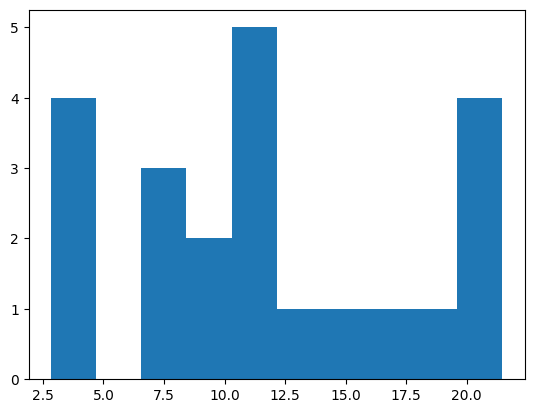

In [19]:
print(len(all_rel_errors))
plt.hist(all_rel_errors)
plt.show()

Below, relative errors indicate peaks denoted by purple lines from left to right
Relative error for peak 1 of the OpenSim Angle curve vs synced Movenet estimation is  15.07%


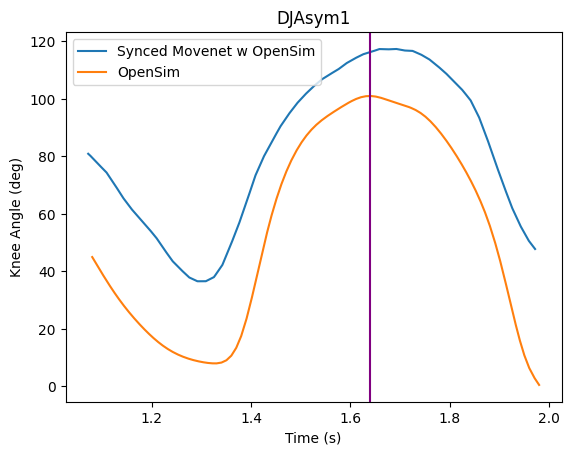

Below, relative errors indicate peaks denoted by purple lines from left to right
Relative error for peak 1 of the OpenSim Angle curve vs synced Movenet estimation is  12.32%


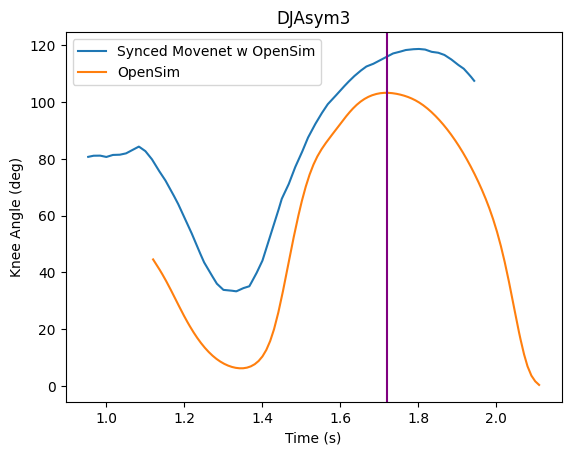

Below, relative errors indicate peaks denoted by purple lines from left to right
Relative error for peak 1 of the OpenSim Angle curve vs synced Movenet estimation is  16.9%


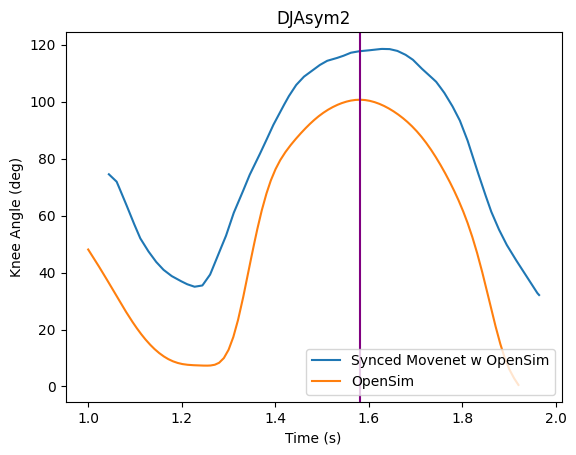

Below, relative errors indicate peaks denoted by purple lines from left to right
Relative error for peak 1 of the OpenSim Angle curve vs synced Movenet estimation is  21.46%
Relative error for peak 2 of the OpenSim Angle curve vs synced Movenet estimation is  21.35%
Relative error for peak 3 of the OpenSim Angle curve vs synced Movenet estimation is  20.38%
Relative error for peak 4 of the OpenSim Angle curve vs synced Movenet estimation is  19.86%
Relative error for peak 5 of the OpenSim Angle curve vs synced Movenet estimation is  18.25%


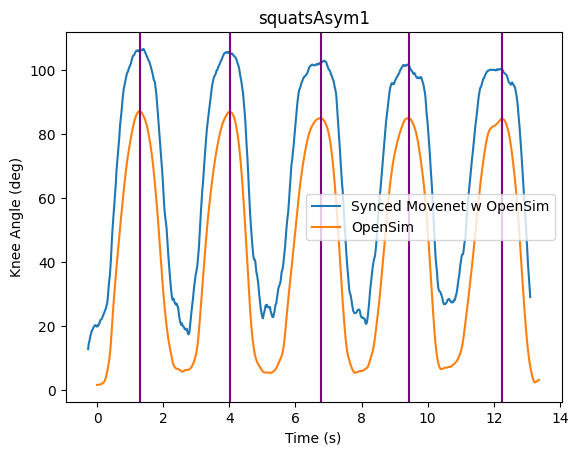

Below, relative errors indicate peaks denoted by purple lines from left to right
Relative error for peak 1 of the OpenSim Angle curve vs synced Movenet estimation is  7.66%


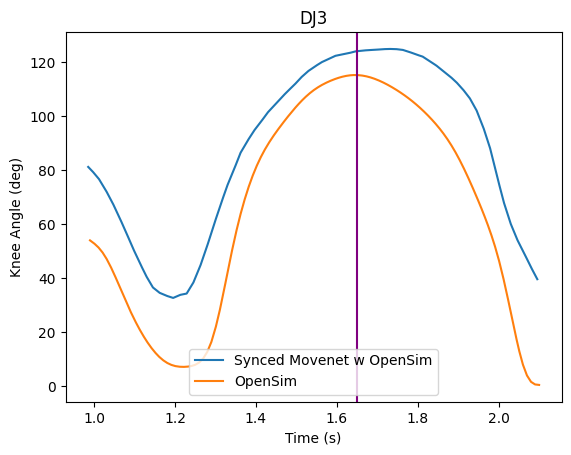

Below, relative errors indicate peaks denoted by purple lines from left to right
Relative error for peak 1 of the OpenSim Angle curve vs synced Movenet estimation is  9.86%


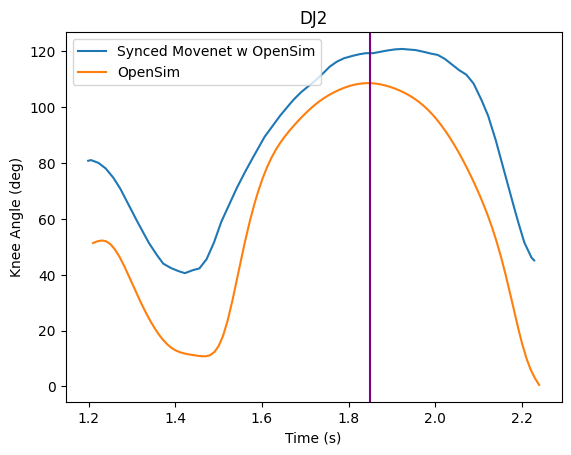

Below, relative errors indicate peaks denoted by purple lines from left to right
Relative error for peak 1 of the OpenSim Angle curve vs synced Movenet estimation is  3.14%
Relative error for peak 2 of the OpenSim Angle curve vs synced Movenet estimation is  7.84%
Relative error for peak 3 of the OpenSim Angle curve vs synced Movenet estimation is  3.24%
Relative error for peak 4 of the OpenSim Angle curve vs synced Movenet estimation is  4.07%
Relative error for peak 5 of the OpenSim Angle curve vs synced Movenet estimation is  2.84%
Relative error for peak 6 of the OpenSim Angle curve vs synced Movenet estimation is  8.33%


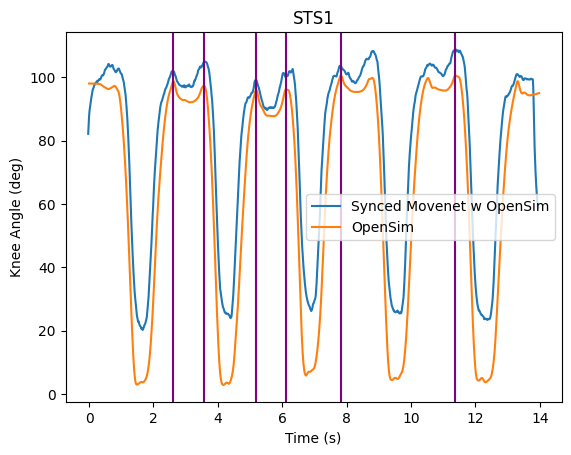

Below, relative errors indicate peaks denoted by purple lines from left to right
Relative error for peak 1 of the OpenSim Angle curve vs synced Movenet estimation is  8.58%


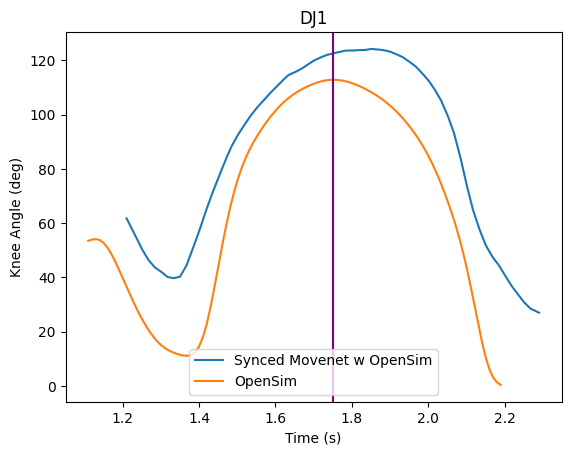

Below, relative errors indicate peaks denoted by purple lines from left to right
Relative error for peak 1 of the OpenSim Angle curve vs synced Movenet estimation is  11.42%
Relative error for peak 2 of the OpenSim Angle curve vs synced Movenet estimation is  10.87%
Relative error for peak 3 of the OpenSim Angle curve vs synced Movenet estimation is  11.78%
Relative error for peak 4 of the OpenSim Angle curve vs synced Movenet estimation is  10.33%
Relative error for peak 5 of the OpenSim Angle curve vs synced Movenet estimation is  11.61%


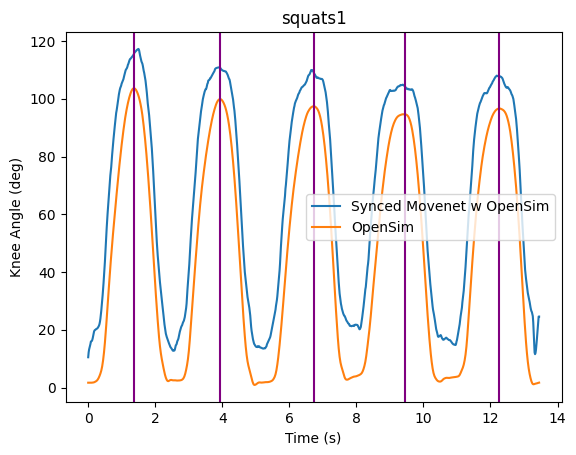

Average Relative Error is 11.861501713979475


In [20]:
for trial_index, (movenet_x, movenet_y, opensim_x, opensim_y, optimal_x) in enumerate(zip(
    movenet_x_data, movenet_y_data, opensim_x_data, opensim_y_data, optimal_xs)):   
    # Plot curves
    plt.plot(movenet_x, movenet_y, label="Synced Movenet w OpenSim")
    plt.plot(opensim_x, opensim_y, label="OpenSim")
    plt.title(trial_names[trial_index])
    plt.xlabel("Time (s)")
    plt.ylabel("Knee Angle (deg)")
    # plt.xlim(time_arrays[trial_index][0]+start_times[trial_index],time_arrays[trial_index][-1]+start_times[trial_index])

    # Analyze peaks
    peaks_o = find_peaks(opensim_y, prominence=5)
    i = 1
    print("Below, relative errors indicate peaks denoted by purple lines from left to right")
    for p in peaks_o[0]:
        if p - optimal_x < 0 or p >= len(opensim_y) or p - optimal_x >=len(opensim_y):
            continue
        rel_error = abs(100*(opensim_y[p] - movenet_y[p-optimal_x])/opensim_y[p])
        # rel_error = abs(opensim_y[p] - movenet_y[p-optimal_x])
        print(str("Relative error for peak " + str(i) + " of the OpenSim Angle curve vs synced Movenet estimation is  "+str(np.round(rel_error, decimals=2))+"%"))
        plt.axvline(opensim_x[p], c='purple')
        i += 1
    plt.legend()
    plt.show()

print("Average Relative Error is", np.mean(av_rel_errors))